In [1]:
pip install xeger

  Created wheel for xeger: filename=xeger-0.3.5-cp36-none-any.whl size=4743 sha256=cb66fa4c01e39a85c090121870c21edb25d744aa24028abff52b2588c1f6f7df
  Stored in directory: /root/.cache/pip/wheels/4c/f6/28/ee8242f69d847db648cd634839f5088540df91d5e8f5d267b4
Successfully built xeger


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from xeger import Xeger
import re



class RegularAutomata(object):

    def __init__(self, regex, max_len=30):
        self.regex = regex
        self.generator = Xeger(limit=10)
        self.checker = re.compile(self.regex)
        self.max_len = max_len

    def generate_pos_data(self):
        while True:
            gen = self.generator.xeger(self.regex)
            if len(gen) <= self.max_len:
                return gen


    def validate(self, src):
        test = self.checker.fullmatch(src)
        if test is not None:
            return test[0] == src
        return False

    def try_generate_neg_data(self):
        prob = random.random()
        if prob < 0.2:
            gen = list(self.generate_pos_data())
            random.shuffle(gen)
            gen = ''.join(gen)
            return gen

        else:
            gen = list(self.generate_pos_data())
            for _ in range(random.randint(0, 5)):
                i = random.randint(0, len(gen) - 1)
                j = random.randint(0, len(gen) - 1)
                if random.random() > 0.8:
                    gen[j] = gen[i]
                else :
                    gen[i], gen[j] = gen[j], gen[i]
            gen = ''.join(gen)
            return gen

    def generate_neg_data(self):
        while True:
            gen = self.try_generate_neg_data()
            if not self.validate(gen):
                return gen
        
    def generate_data(self, num_pos, num_neg):
        data = []
        label = []
        for _ in range(num_pos):
            pos = self.generate_pos_data()
            data.append(self.generate_pos_data())
            label.append(True)

        for _ in range(num_neg):
            data.append(self.generate_neg_data())
            label.append(False)

        return data, label
        

            




In [3]:
class Model(nn.Module):

    def __init__(self, n_in, n_hid):
        super().__init__()
        self.embedding = nn.Embedding(n_in, n_hid)
        self.layer1 = nn.Sequential(nn.Dropout(0.5), nn.Linear(n_hid, n_hid), nn.ReLU())
        self.rnn = nn.GRUCell(n_hid, n_hid)
        self.layer2 = nn.Sequential(nn.Linear(n_hid, n_hid), nn.ReLU(), nn.Linear(n_hid, 1), nn.Sigmoid())
        self.start = nn.Parameter(nn.init.xavier_uniform_(torch.empty(1, n_hid)))

    def forward(self, x):
        mbsz, n_seq = x.size(0), x.size(1)
        x = self.embedding(x).view(mbsz * n_seq, -1)
        x = self.layer1(x).view(mbsz, n_seq, -1).transpose(0, 1).contiguous()
        h = self.start.expand(mbsz, -1)
        state = []
        for i in range(n_seq):
            h = self.rnn(x[i], h)
            h = F.dropout(h, 0.5)
            state.append(h)
        

        state = torch.stack(state, dim=0).transpose(0, 1)

        y = state.reshape(mbsz * n_seq, -1)

        y = self.layer2(y).view(mbsz, n_seq, -1).squeeze(2)
        return state, y






In [6]:

ra = RegularAutomata("[a-d]{2,}@[a-d]{2,}\.[v-z]{2,3}", 30)
data, label = ra.generate_data(50000, 50000)
alphabet = ['a', 'b', 'c', 'd', '@', '.', 'v', 'w', 'x', 'y', 'z']
char2idx = {c:i for i, c in enumerate(alphabet)}


In [7]:
from torch.utils.data import Dataset, DataLoader
from functools import partial
import torch.nn.functional as F
class Dataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


def pad_and_pack(char2idx_dic, batch): 
    batch_size = len(batch)
    
    seq_len = [len(batch[i][0]) for i in range(batch_size)]
    
    seq_len = torch.LongTensor(seq_len)

    x = torch.zeros(batch_size, max(seq_len)).long()
    for i in range(len(batch)):
        for j in range(len(batch[i][0])):
            x[i][j] = char2idx_dic[batch[i][0][j]]
    
    y = torch.BoolTensor([batch[i][1] for i in range(batch_size)])

    return x, y, seq_len

collate_fn = partial(pad_and_pack, char2idx)
dataset = Dataset(data, label)
loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=collate_fn)

In [9]:
net = Model(len(alphabet), 16)

solver = optim.Adam(net.parameters(), 0.001)

In [11]:

num_epochs = 20
for epoch in range(num_epochs):
    LOSS = 0.0
    for batch in loader:
        x, y, seq_len = batch
        seq_len = seq_len

        solver.zero_grad()
        state, pred = net(x)

        pred = torch.gather(pred, 1, seq_len.unsqueeze(1) - 1).squeeze(1)
        
        loss = F.binary_cross_entropy(pred, y.float(), reduction='mean')
        loss.backward()
        solver.step()
        LOSS += loss.item()
    LOSS /= len(loader)
    print(LOSS)


0.2782585959517956
0.18527725181937219
0.1700535208296776
0.16656814011871815
0.1643565346878767
0.16233559909641743
0.16113875031411648
0.16309281997621058
0.1606857737505436
0.16131624654114246
0.16002477791845798
0.15959455471217632
0.15987419236183167
0.15945689024567605
0.158982307228446
0.15820688558161258
0.15878813032686712
0.15841556590914727
0.15949047546684741
0.15775613664865493


In [12]:
net.eval()
state = []
with torch.no_grad():
    
    for i in range(1000):
        x = ra.generate_pos_data()
        x = [char2idx[chr] for chr in x]
        x = torch.LongTensor(x).unsqueeze(0)
        s, _ = net(x)
        
        state.append(s.squeeze(0))
    state = torch.cat(state, dim=0)
    print(state.shape)
    

torch.Size([16551, 16])


In [13]:
from sklearn.manifold import TSNE
X = state.numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)

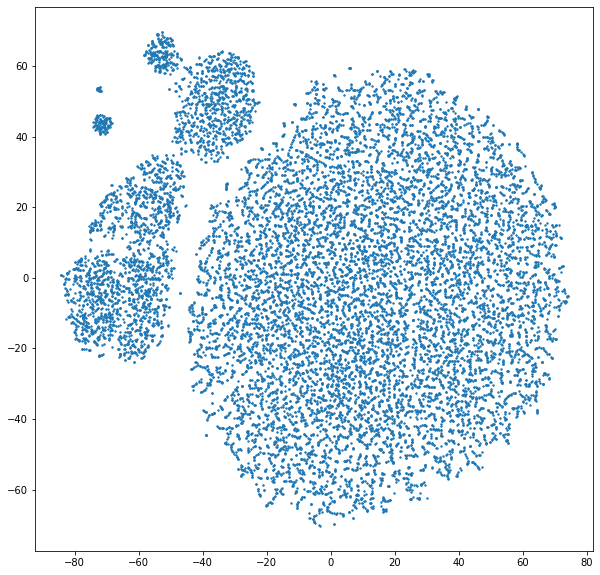

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=2)
plt.show()